In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using Pkg
Pkg.activate("../..")
Pkg.status()

  Activating environment at `~/Dropbox/class/M1399.000200/2021/M1399_000200-2021fall/Project.toml`


      Status `~/Dropbox/class/M1399.000200/2021/M1399_000200-2021fall/Project.toml`
  [7d9fca2a] Arpack v0.3.2
  [6e4b80f9] BenchmarkTools v1.2.0
  [1e616198] COSMO v0.8.1
  [f65535da] Convex v0.14.16
  [a93c6f00] DataFrames v0.21.8
  [31a5f54b] Debugger v0.6.8
  [31c24e10] Distributions v0.24.18
  [e2685f51] ECOS v0.12.3
  [f6369f11] ForwardDiff v0.10.21
  [28b8d3ca] GR v0.50.1
  [c91e804a] Gadfly v1.3.3
  [bd48cda9] GraphRecipes v0.5.5
  [82e4d734] ImageIO v0.0.1
  [6218d12a] ImageMagick v0.7.9
  [916415d5] Images v0.23.3
  [b6b21f68] Ipopt v0.7.0
  [42fd0dbc] IterativeSolvers v0.8.5
  [4076af6c] JuMP v0.21.4
  [b51810bb] MatrixDepot v1.0.4
  [1ec41992] MosekTools v0.9.4
  [76087f3c] NLopt v0.5.1
  [47be7bcc] ORCA v0.3.1
  [a03496cd] PlotlyBase v0.3.1
  [f0f68f2c] PlotlyJS v0.13.1
  [91a5bcdd] Plots v1.4.3
  [438e738f] PyCall v1.92.3
  [d330b81b] PyPlot v2.10.0
  [dca85d43] QuartzImageIO v0.7.3
  [6f49c342] RCall v0.13.12
  [ce6b1742] RDatasets v0.7.5
  [c946c3f1] SCS v0.7.1
  [276da

# Conditioning of linear regression by least squares

* Recall that for nonsingular linear equation solve, i.e. $\mathbf{A}\mathbf{x} = \mathbf{b}$, the condition number  of the problem with $\mathbf{b}$ held fixed is equal to the condition number of matrix $\mathbf{A}$
$$
    \kappa(\mathbf{A}) = \|\mathbf{A}\|\|\mathbf{A}^{-1}\|.
$$

* If $\mathbf{A}$ is not square, then its condition number is
$$
    \kappa(\mathbf{A}) = \|\mathbf{A}\|\|\mathbf{A}^{\dagger}\|,
$$
where $\mathbf{A}^{\dagger}$ is Moore-Penrose pseudoinverse of $\mathbf{A}$.

* **Condition number for the least squares problem** $\mathbf{y} \approx \mathbf{X}\boldsymbol{\beta}$ is more complicated and depends on the residual. It can be shown that the condition number is
$$
    \kappa(\mathbf{X}) + \frac{\kappa(\mathbf{X})^2\tan\theta}{\eta},
$$
where

$$
    \theta = \cos^{-1}\frac{\|\mathbf{X}\boldsymbol{\beta}\|}{\|\boldsymbol{\beta}\|},
    \quad
    \eta = \frac{\|\mathbf{X}\|\|\boldsymbol{\beta}\|}{\|\mathbf{X}\boldsymbol{\beta}\|}
    .
$$

* So if $\kappa(\mathbf{X})$ is large ($\mathbf{X}$ is close to collinear), the condition number of the least squares problem is dominated by $\kappa(\mathbf{X})^2=\kappa(\mathbf{X}^T\mathbf{X})$, unless the residuals are small. 
    - In this case, *stable* algorithm is preferred.

* This is because the problem is equivalent to the normal equation
$$
    \mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}.
$$
    
* Consider the simple case where columns of $X$ are nearly collinear so that $\kappa(X)$ is large
$$
\begin{align*}
	\mathbf{X} = \begin{bmatrix}
	1 & 1 \\
	10^{-3} & 0 \\
	0 & 10^{-3}
	\end{bmatrix}.
\end{align*}
$$
Mathematically, a Gram matrix is not singular.
$$
\begin{align*}
	\mathbf{X^TX} = 
	\begin{bmatrix}
		1+10^{-6} & 1 \\
		1 & 1+10^{-6}
	\end{bmatrix}
\end{align*}
$$
But numerically, if executed with a precision of 6 decimal digits, forming normal equation yields a singular Gram matrix
$$
\begin{align*}
	\mathbf{X}^T \mathbf{X} = \begin{bmatrix}
	1 & 1 \\
	1 & 1
	\end{bmatrix}
\end{align*}
$$
This has the condition number $\kappa(\mathbf{X}^T\mathbf{X})=\infty$.

## Longley example

The [Longley (1967)](https://www.jstor.org/stable/2283673?seq=1#page_scan_tab_contents) macroeconomic [data set](https://www.itl.nist.gov/div898/strd/lls/data/Longley.shtml) is a famous test example for numerical software in early dates.

* [Link to download](./longley.txt)

In [3]:
using DelimitedFiles

longley = readdlm("./data/longleydata.txt")

# Time Series data : observed yearly from 1947 to 1962 written in each row
# Correlation between the rows are quite large.

16×7 Matrix{Float64}:
 60323.0   83.0  234289.0  2356.0  1590.0  107608.0  1947.0
 61122.0   88.5  259426.0  2325.0  1456.0  108632.0  1948.0
 60171.0   88.2  258054.0  3682.0  1616.0  109773.0  1949.0
 61187.0   89.5  284599.0  3351.0  1650.0  110929.0  1950.0
 63221.0   96.2  328975.0  2099.0  3099.0  112075.0  1951.0
 63639.0   98.1  346999.0  1932.0  3594.0  113270.0  1952.0
 64989.0   99.0  365385.0  1870.0  3547.0  115094.0  1953.0
 63761.0  100.0  363112.0  3578.0  3350.0  116219.0  1954.0
 66019.0  101.2  397469.0  2904.0  3048.0  117388.0  1955.0
 67857.0  104.6  419180.0  2822.0  2857.0  118734.0  1956.0
 68169.0  108.4  442769.0  2936.0  2798.0  120445.0  1957.0
 66513.0  110.8  444546.0  4681.0  2637.0  121950.0  1958.0
 68655.0  112.6  482704.0  3813.0  2552.0  123366.0  1959.0
 69564.0  114.2  502601.0  3931.0  2514.0  125368.0  1960.0
 69331.0  115.7  518173.0  4806.0  2572.0  127852.0  1961.0
 70551.0  116.9  554894.0  4007.0  2827.0  130081.0  1962.0

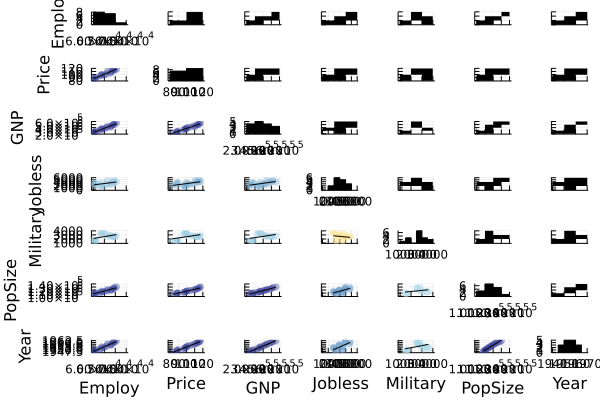

In [4]:
using StatsPlots
gr()

corrplot(longley, 
    label = ["Employ" "Price" "GNP" "Jobless" "Military" "PopSize" "Year"])
# Correlation between columns(variables)

In [5]:
# response: Employment
y = longley[:, 1]
# predictor matrix
X = [ones(length(y)) longley[:, 2:end]]

16×7 Matrix{Float64}:
 1.0   83.0  234289.0  2356.0  1590.0  107608.0  1947.0
 1.0   88.5  259426.0  2325.0  1456.0  108632.0  1948.0
 1.0   88.2  258054.0  3682.0  1616.0  109773.0  1949.0
 1.0   89.5  284599.0  3351.0  1650.0  110929.0  1950.0
 1.0   96.2  328975.0  2099.0  3099.0  112075.0  1951.0
 1.0   98.1  346999.0  1932.0  3594.0  113270.0  1952.0
 1.0   99.0  365385.0  1870.0  3547.0  115094.0  1953.0
 1.0  100.0  363112.0  3578.0  3350.0  116219.0  1954.0
 1.0  101.2  397469.0  2904.0  3048.0  117388.0  1955.0
 1.0  104.6  419180.0  2822.0  2857.0  118734.0  1956.0
 1.0  108.4  442769.0  2936.0  2798.0  120445.0  1957.0
 1.0  110.8  444546.0  4681.0  2637.0  121950.0  1958.0
 1.0  112.6  482704.0  3813.0  2552.0  123366.0  1959.0
 1.0  114.2  502601.0  3931.0  2514.0  125368.0  1960.0
 1.0  115.7  518173.0  4806.0  2572.0  127852.0  1961.0
 1.0  116.9  554894.0  4007.0  2827.0  130081.0  1962.0

In [6]:
using LinearAlgebra

# Julia function for obtaining condition number
cond(X)
# condition number is very large

4.859257015454868e9

In [7]:
# we see the smallest singular value (aka trouble number) is very small
xsvals = svdvals(X)

7-element Vector{Float64}:
     1.6636682278894703e6
 83899.57794622083
  3407.197376095864
  1582.6436810037958
    41.69360109707282
     3.6480937948061642
     0.00034237090621018257

In [8]:
# condition number of the design matrix
xcond = maximum(xsvals) / minimum(xsvals)

4.859257015454868e9

In [9]:
# X is full rank from SVD
xrksvd = rank(X)

7

In [10]:
# least squares from QR
X \ y

7-element Vector{Float64}:
   -3.482258634593727e6
   15.061872271247157
   -0.03581917929254079
   -2.020229803816271
   -1.0332268671735425
   -0.051104105653446294
 1829.15146461247

In [11]:
# Gram matrix
G = X'X

7×7 Matrix{Float64}:
    16.0        1626.9        6.20318e6   …  1.87878e6  31272.0
  1626.9           1.67172e5  6.46701e8      1.9214e8       3.18054e6
     6.20318e6     6.46701e8  2.55315e12     7.3868e11      1.21312e10
 51093.0           5.28908e6  2.06505e10     6.06649e9      9.99059e7
 41707.0           4.29317e6  1.66329e10     4.92386e9      8.15371e7
     1.87878e6     1.9214e8   7.3868e11   …  2.2134e11      3.67258e9
 31272.0           3.18054e6  1.21312e10     3.67258e9      6.11215e7

In [12]:
# rank of Gram matrix from SVD
# rank deficient! We lost precision when forming Gram matrix
rank(G)

# order of maginitude of entries are very different to each other. This may cause numerical problems
# Mathematically rank(X)=rank(X'X) but numerically due to the round-off error in calculating dot products, rank deficiency can occur.

6

In [13]:
svdvals(G)
# From this, we can figure out that magnitude of k(X'X) is an order of 10^19 , which is square of the maginitude of k(X)

7-element Vector{Float64}:
    2.7677919724888896e12
    7.039139179553959e9
    1.160899395967452e7
    2.5047610210212315e6
 1738.3563724374112
   13.308588281731947
    1.1609902991000544e-7

In [14]:
# rank of Gram matrix from cholesky
# full!
gchol = cholesky(Symmetric(G), Val(true))
rank(gchol)

7

In [15]:
# least squares solution from Cholesky matches those from QR
gchol \ (X'y)

7-element Vector{Float64}:
   -3.4822586014639004e6
   15.061871708275818
   -0.03581917829703869
   -2.02022978887794
   -1.033226862813952
   -0.05110410889940152
 1829.1514476585419

* Now let us re-run above example using **single precision**. Problem occurs here...

In [13]:
Xsp = Float32.(X)
ysp = Float32.(y)

# least squares by QR: dramatically different from Float64 solution
# This is because condition number of the problem is too large so that small perturbation in the input can cause large difference in the output
Xsp \ ysp

7-element Vector{Float32}:
   0.023724092
 -52.995304
   0.07107309
  -0.42346963
  -0.57256323
  -0.41419855
  48.417664

In [14]:
# least squares by Cholesky: failed
# Even more catastrophic difference to double precision case than using QR ...
G = Xsp'Xsp
gchol = cholesky(Symmetric(G), Val(true), check=false)
gchol \ (Xsp'ysp)

7-element Vector{Float32}:
     -4.724464f10
     -1.258656f6
   -884.32623
 -14967.619
  -5718.0063
   -647.4038
      2.4484148f7

In [16]:
rank(Xsp)
# Note that rank(X) was 7 in double precision

6

In [17]:
# rank of Gram matrix by Cholesky
rank(gchol)

6

In [18]:
# rank of Gram matrix by SVD
rank(G)

4

* **Standardizing the predictors** improves the condition.

In [19]:
using StatsBase

# center and standardize matrix along dimension 1
Xcs = zscore(X[:, 2:end], 1)
Xcs = [ones(length(y)) Xcs]

# All entries have similar order of magnitudes so that condition number will be reduced.
# Also it makes the data scale-free, which facilitates the interpretation of beta coefficients.
# These are the reasons why we standardize the design matrix.

16×7 Matrix{Float64}:
 1.0  -1.7311     -1.54343    -0.896035  -1.46093    -1.41114     -1.57532
 1.0  -1.22144    -1.29053    -0.929209  -1.65348    -1.26393     -1.36527
 1.0  -1.24924    -1.30434     0.52296   -1.42357    -1.0999      -1.15523
 1.0  -1.12878    -1.03727     0.168746  -1.37471    -0.933713    -0.945189
 1.0  -0.50792    -0.590809   -1.17106    0.707427   -0.768965    -0.735147
 1.0  -0.331857   -0.409472   -1.34977    1.41872    -0.597174    -0.525105
 1.0  -0.248458   -0.224493   -1.41612    1.35118    -0.334958    -0.315063
 1.0  -0.155793   -0.247361    0.411666   1.0681     -0.173229    -0.105021
 1.0  -0.0445951   0.0983004  -0.309603   0.634143   -0.00517531   0.105021
 1.0   0.270466    0.316732   -0.397353   0.359686    0.188324     0.315063
 1.0   0.622593    0.554058   -0.275358   0.274906    0.434295     0.525105
 1.0   0.84499     0.571936    1.59202    0.0435575   0.650652     0.735147
 1.0   1.01179     0.955839    0.663147  -0.0785831   0.854214     0.

In [20]:
cond(Xcs)

110.54415344231359

In [21]:
rank(Xcs)

7

In [22]:
rank(Xcs'Xcs)

7

# Summary of linear regression

Methods for solving linear regression $\widehat \beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$ (Assume that $\mathbf{X}$ is linear independent mathematically) :

| Method            | Flops                  | Remarks                 | Software | Stability   |
| :---------------: | :--------------------: | :---------------------: | :------: | :---------: |
| Cholesky          | $np^2 + p^3/3$         |                         |          | unstable |
| QR by Householder | $2np^2 - (2/3)p^3$     |                         | R, Julia, MATLAB     | stable      |
| QR by MGS         | $2np^2$                | $Q_1$ available         |          | stable      | 
| SVD         | $4n^2p + 8np^2 + 9p^3$ | $X = UDV^T$             |          | most stable |  

Remarks:

1. When $n \gg p$, Cholesky is twice faster than QR and need less space.  
2. Cholesky is based on the **Gram matrix** $\mathbf{X}^T \mathbf{X}$, which can be dynamically updated with incoming data. They can handle huge $n$, moderate $p$ data sets that cannot fit into memory.  
    - Consider an online setting, where new data keep coming. Then the row of matrix $\mathbf{X}$ increases one by one. If the new data is $\tilde x^T$ then updated design matrix is $\tilde{\mathbf{X}}=\begin{bmatrix} \mathbf{X} \\ \tilde x^T \end{bmatrix}$. 
    - So we can calculate new Gram matrix by $\tilde{\mathbf{X}}^T\tilde{\mathbf{X}}=X^TX+\tilde{x}\tilde{x}^T$ i.e. adding a rank-one matrix to current gram matrix.
3. QR methods are more stable and produce numerically more accurate solution.  
4. MGS(Modified Gram-Schmidt) appears slower than Householder, but it yields $\mathbf{Q}_1$
    - Recall that normal equation only requires $\mathbf{R}_1\beta = \mathbf{Q}_1^T\mathbf{y}$ . Calculating just $\mathbf{Q}_1$ rather than the whole matrix $\mathbf{Q}$ is more economic.


> **There is simply no such thing as a universal 'gold standard' when it comes to algorithms.**
- Cholesky : $\mathbf{L}\mathbf{L}^T\beta=X^Ty\quad$ QR : $\mathbf{R}_1\beta = \mathbf{Q}_1^T\mathbf{y}\quad$ SVD : $\beta=VD^{-1}U^Ty$
- Cholesky $\rightarrow$ QR $\rightarrow$ SVD : cost (elapsed time and allocated memory) gets large . stability of algorithm goes up.
- If you want to sacrifice time and memory cost to get high stability, you should use SVD

In [23]:
using BenchmarkTools, LinearAlgebra

linreg_cholesky(y::Vector, X::Matrix) = cholesky!(X'X) \ (X'y)

linreg_qr(y::Vector, X::Matrix) = X \ y

function linreg_svd(y::Vector, X::Matrix)
    xsvd = svd(X)
    return xsvd.V * ((xsvd.U'y) ./ xsvd.S)
    # X'Xb = X'y --> VDDV'b = VDU'y --> V'b=D^{-1}U'y --> b = VD^{-1}U'y        since V'V = VV' = I
end

linreg_svd (generic function with 1 method)

In [24]:
using Random

Random.seed!(280) # seed

n, p = 10, 3
X = randn(n, p)
y = randn(n)

# check these methods give same answer
@show linreg_cholesky(y, X)
@show linreg_qr(y, X)
@show linreg_svd(y, X);

linreg_cholesky(y, X) = [0.007934502488360664, -0.10565972819262025, 0.20946283851564207]
linreg_qr(y, X) = [0.007934502488360664, -0.10565972819262029, 0.20946283851564215]
linreg_svd(y, X) = [0.007934502488360709, -0.10565972819262025, 0.2094628385156421]


In [25]:
n, p = 1000, 300
X = randn(n, p)
y = randn(n)

@benchmark linreg_cholesky(y, X)

BenchmarkTools.Trial: 2129 samples with 1 evaluation.
 Range (min … max):  1.724 ms …   8.362 ms  ┊ GC (min … max): 0.00% … 48.61%
 Time  (median):     2.178 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.328 ms ± 646.229 μs  ┊ GC (mean ± σ):  2.41% ±  7.24%

     █▂                                                        
  ▇▃▃██▅▆▇▆▇▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▂▂▁▂ ▃
  1.72 ms         Histogram: frequency by time         6.4 ms <

 Memory estimate: 708.25 KiB, allocs estimate: 6.

In [26]:
@benchmark linreg_qr(y, X)

BenchmarkTools.Trial: 391 samples with 1 evaluation.
 Range (min … max):   9.330 ms … 26.462 ms  ┊ GC (min … max): 0.00% … 22.25%
 Time  (median):     12.011 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.787 ms ±  3.019 ms  ┊ GC (mean ± σ):  3.65% ±  9.02%

   ▁▂ ▁ ▁   ▂▃█▄▆▄▃ ▁                                          
  ▆████▇█▅▃▆█████████▅▃▅█▄▃▂▁▁▂▁▂▁▁▁▁▁▂▃▂▃▂▁▂▃▂▄▃▃▆▄▄▃▄▃▄▂▂▃▃ ▃
  9.33 ms         Histogram: frequency by time        20.8 ms <

 Memory estimate: 4.01 MiB, allocs estimate: 1836.

In [27]:
@benchmark linreg_svd(y, X)

BenchmarkTools.Trial: 138 samples with 1 evaluation.
 Range (min … max):  29.533 ms … 58.253 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     33.703 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   36.320 ms ±  7.115 ms  ┊ GC (mean ± σ):  1.81% ± 4.10%

    ▆█▂▁▄ ▆▃  ▅                                                
  ▄▄████████▅▇█▅▃▄▁▄▄▅▄▁▁▁▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▃▁▇▆▃▁▃▃▃▄▁▁▃▁▁▃▁▁▃ ▃
  29.5 ms         Histogram: frequency by time        58.2 ms <

 Memory estimate: 8.06 MiB, allocs estimate: 14.

## Underdetermined least squares

* When the Gram matrix $\mathbf{X}^T\mathbf{X}$ is singular (this happens if $\text{rank}(\mathbf{X})<p$, in particular $n < p$), the normal equation $\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}$ is *underdetermined*.
    - When $n >p$ we call it as tall matrix, while when $n<p$ we call it as fat matrix.

* It has *many* solutions unless an additional condition is added.
    - Assuming $A$ is full row rank, $Ax=b$ has a solution set $x=\hat x+N(A)$ where $\hat x$ is a particular solution.
    - We can choose a solution which has a desired property. 

* Typically we require solution $\mathbf{x}$ has a smallest norm; the solution depends on the choice of the norm.

* Example: minimum $\ell_2$ norm solution
$$
    \text{minimize}~\|\boldsymbol{\beta}\|_2 ~\text{subject to}~\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}
$$
- Solution is closed form: $\hat{\boldsymbol{\beta}} = \mathbf{X}^{\dagger}\mathbf{y}$, where $\mathbf{X}^{\dagger}$ is the Moore-Penrose pseudoinverse of $\mathbf{X}$: $\mathbf{X}^{\dagger} = \mathbf{X}^T(\mathbf{X}\mathbf{X}^T)^{-1}$ if $n<p$ and $\mathbf{X}$ has full row rank.
- In fact $\hat{\boldsymbol{\beta}}$ is a limit of the ridge regression: $\hat{\boldsymbol{\beta}} = \lim_{\lambda\to 0}(\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$.
    - Note that $\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I}$ is nongsingular because of $\lambda>0$
    

* Example: minimum $\ell_0$ "norm" solution
$$
    \text{minimize}~\|\boldsymbol{\beta}\|_0 ~\text{subject to}~\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}
$$
- $\|\mathbf{x}\|_0 \triangleq \sum_{i=1}^p \mathbf{1}_{\{x_i\neq 0\}}$, the "sparsest" solution.
- Model selection problem. Combinatorial (intractable if $p$ large).
    
* Compromise: minimum $\ell_1$ norm solution    
$$
    \text{minimize}~\|\boldsymbol{\beta}\|_1 ~\text{subject to}~\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}
$$
- LASSO.
- Convex optimization problem (linear programming). Tractable (even though solution has not closed form).
- Under certain conditions recovers the minimum $\ell_0$ norm solution. (This is why minimum $\ell_1$ norm solution is favored.)

## Further reading

* Chapter 6 of [Numerical Analysis for Statisticians](http://ucla.worldcat.org/title/numerical-analysis-for-statisticians/oclc/793808354&referer=brief_results) of Kenneth Lange (2010).

* Section 2.6 of [Matrix Computation](http://catalog.library.ucla.edu/vwebv/holdingsInfo?bibId=7122088) by Gene Golub and Charles Van Loan (2013).

## Acknowledgment

Many parts of this lecture note is based on [Dr. Hua Zhou](http://hua-zhou.github.io)'s 2019 Spring Statistical Computing course notes available at <http://hua-zhou.github.io/teaching/biostatm280-2019spring/index.html>.